In [229]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import importlib
import scipy as sp

%matplotlib ipympl
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
# plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
np.set_printoptions(linewidth=300, formatter={'float': '{:.12f}'.format})
# np.set_printoptions(linewidth=200, formatter={'float': '{:.1e}'.format})

In [3]:
nH = 1e-9
fF = 1e-15
GHz = 1e9
h    = 6.626e-34
e0   = 1.602e-19
Φ_0 = h/(2*e0)

# Experimental parameters for the actual qubits

In [160]:
L_F_eff_1 = 26.5
L_F_eff_2 = 20.4
L_F_eff_3 = 32.2

C_F_eff_1 = 26.9
C_F_eff_2 = 22.4
C_F_eff_3 = 24.8

EJ_1 = 5.4
EJ_2 = 9.5
EJ_3 = 5.6

E_L_1 = sq_ext.L_to_EL(L_F_eff_1)
E_L_2 = sq_ext.L_to_EL(L_F_eff_2)
E_L_3 = sq_ext.L_to_EL(L_F_eff_3)

E_C_1 = sq_ext.C_to_EC(C_F_eff_1)
E_C_2 = sq_ext.C_to_EC(C_F_eff_2)
E_C_3 = sq_ext.C_to_EC(C_F_eff_3)

experiment_coords = [ (EJ_1/E_L_1, E_C_1/E_L_1),
                      (EJ_2/E_L_2, E_C_2/E_L_2),
                      (EJ_3/E_L_3, E_C_3/E_L_3)]

omega_q_exp = [3.7001944890642844, 3.4505095260121497, 3.0342472605322786]
experiment_colors = ['b', 'g', 'r']
ω_r_1 = 6.46
ω_r_2 = 6.274
ω_r_3 = 5.22
ω_r_exp = [6.46, 6.274, 5.22] 

In [194]:
n_eig  = 5
n_plot = 50
param_name = '\\Delta'
param_values = np.geomspace(1e-4, 1e1, n_plot)
Δ_values = param_values

In [195]:
EJ =           EJ_1
C_F_eff = C_F_eff_1
L_F_eff = L_F_eff_1
ω_r         = ω_r_1

In [196]:
L_R_eff = 15
C_R_eff = 1/ (L_R_eff* nH)  /(ω_r*2*np.pi*GHz)**2/fF

In [225]:
Pauli_p1 = []
Pauli_p2 = []
Pauli_SWT = []
ω_f_minus_ω_r = [] 
g_r_limit=np.zeros(len(Δ_values))
g_fq_limit=np.zeros(len(Δ_values))

for i, Δ in enumerate(Δ_values):
    fluxonium = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, Lq=L_F_eff, Δ=Δ)
    resonator = sq_ext.sq_resonator(Lr=L_R_eff, C_R_eff=C_R_eff, Δ=Δ)
    H_0 = sq_ext.hamiltonian_qubit(Lq=L_F_eff, Lr=L_R_eff, fluxonium = fluxonium, resonator = resonator, Δ=0) 
    H   = sq_ext.hamiltonian_qubit(Lq=L_F_eff, Lr=L_R_eff, fluxonium = fluxonium, resonator = resonator, Δ=Δ) 
    H_eff_p1  = sq_ext.H_eff_p1 (H_0, H, n_eig, real = True, remove_ground=True)
    H_eff_p2  = sq_ext.H_eff_p2 (H_0, H, n_eig, real = True, remove_ground=True)
    H_eff_SWT = sq_ext.H_eff_SWT(H_0, H, n_eig, real = True, remove_ground=True)
    
    if i ==0:
        Nf, Nr = sq_ext.sq_get_energy_indices_hamiltonian(H_qubit = H_0, H_fluxonium=fluxonium.hamiltonian(), H_resonator=resonator.hamiltonian(), n_eig=5)
        subspace_indices = np.intersect1d(np.where(Nf<=1), np.where(Nr<=1)).tolist()
    
    H_eff_p1_subspace   = H_eff_p1  [subspace_indices][:, subspace_indices]
    H_eff_p2_subspace   = H_eff_p2  [subspace_indices][:, subspace_indices]
    H_eff_SWT_subspace  = H_eff_SWT [subspace_indices][:, subspace_indices]
    
    Pauli_p1.append(sq_ext.decomposition_in_pauli_4x4   (H_eff_p1_subspace, print_pretty=False))
    Pauli_p2.append(sq_ext.decomposition_in_pauli_4x4   (H_eff_p2_subspace, print_pretty=False))
    Pauli_SWT.append(sq_ext.decomposition_in_pauli_4x4  (H_eff_SWT_subspace, print_pretty=False))
    ω_f_minus_ω_r.append(H_eff_p1_subspace[2,2]-H_eff_p1_subspace[1,1])
    
    # Analytic estimation of coupling
    Lq = L_F_eff
    Lr = L_R_eff
    C_f = C_F_eff_1 * fF
    C_r = C_R_eff * fF  
    l = Lq*(Lq+4*Lr) - 4*Δ**2
    Lf = l/(Lq+4*Lr)
    Lres = l/Lq
    L_f = Lf * nH
    L_r = Lres * nH
    E_L_f = sq_ext.L_to_EL(Lf)
    V =  lambda φ: E_L_f*φ**2/2 - EJ*GHz*np.cos(φ+np.pi)
    φ_min = sp.optimize.minimize_scalar(V).x
    Φ_f_fq_limit_01 = (Φ_0 / (2 * np.pi)) * φ_min / np.sqrt(sq.hbar) 
    Φ_f_r_limit_01  = np.sqrt(0.5*np.sqrt(L_f/C_f))
    Φ_r_01 = np.sqrt(0.5*np.sqrt(L_r/C_r))
    g_fq_limit[i] = 2 * Δ / (l * nH) * Φ_f_fq_limit_01 * Φ_r_01  /2 / np.pi / GHz
    g_r_limit[i] = 2 * Δ / (l * nH) * Φ_f_r_limit_01 * Φ_r_01 /2 / np.pi / GHz
    
    
Pauli_p1 = np.array(Pauli_p1)
Pauli_p1 = Pauli_p1- Pauli_p1[0,:]

Pauli_p2 = np.array(Pauli_p2)
Pauli_p2 = Pauli_p2- Pauli_p2[0,:]

Pauli_SWT = np.array(Pauli_SWT)
Pauli_SWT = Pauli_SWT- Pauli_SWT[0,:]

ω_f_minus_ω_r = np.array(ω_f_minus_ω_r)

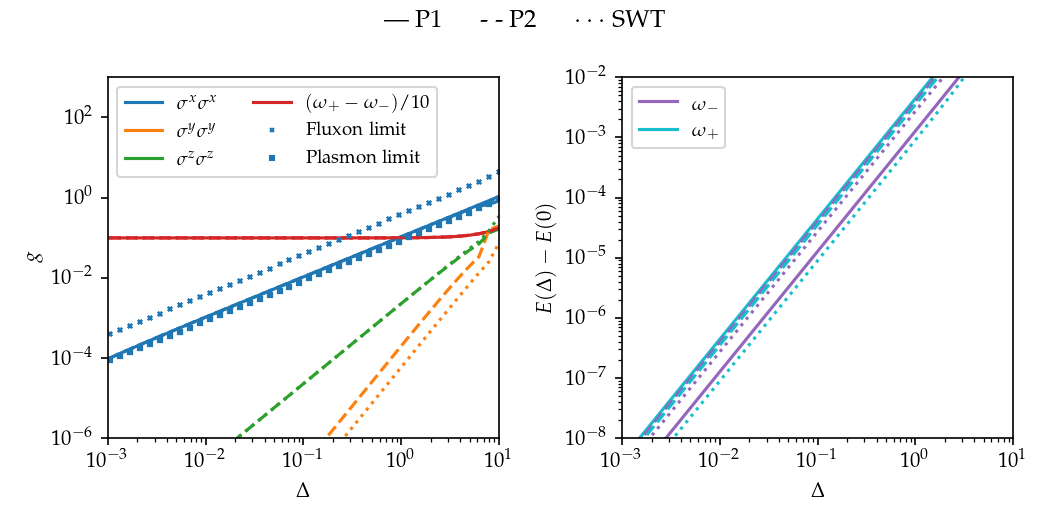

In [241]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize =[7,3.5], dpi=150)
linestyles = ['-', '--',':' ]
colors = figs.generate_colors_from_colormap(10, 'tab10')

for i, Pauli in enumerate([Pauli_p1, Pauli_p2, Pauli_SWT]):
# for i, Pauli in enumerate([Pauli_SWT]):
    # energies_0 = Pauli[:, :,0]
    # energies_1 = Pauli[:, 0,:]
    # couplings  = np.abs(Pauli[:, 1:,1:])
    # ax1.plot(Δ_values, couplings.reshape(n_plot,9), linestyle=linestyles[i])
    # ax2.plot(Δ_values, np.abs(energies_0)         , linestyle=linestyles[i])
    # ax2.plot(Δ_values, np.abs(energies_1)         , linestyle=linestyles[i])
    
    σxσx = np.abs(Pauli[:, 1,1])
    σyσy = np.abs(Pauli[:, 2,2])
    σzσz = np.abs(Pauli[:, 3,3])
    ωf = np.abs(Pauli[:, 0,-1])
    ωr = np.abs(Pauli[:, -1,0])

    ax1.plot(Δ_values, σxσx, color = colors[0], linestyle=linestyles[i], label = r'$\sigma^x\sigma^x$')
    ax1.plot(Δ_values, σyσy, color = colors[1], linestyle=linestyles[i], label = r'$\sigma^y\sigma^y$')
    ax1.plot(Δ_values, σzσz, color = colors[2], linestyle=linestyles[i], label = r'$\sigma^z\sigma^z$')
    ax1.plot(Δ_values, ω_f_minus_ω_r/10 , color = colors[3], linestyle=linestyles[i], label = r'$(\omega_+-\omega_-)/10$')

    ax1.plot(Δ_values, g_fq_limit, 'x', color = colors[0], label = 'Fluxon limit', markersize='2')
    ax1.plot(Δ_values, g_r_limit , 's', color = colors[0], label = 'Plasmon limit', markersize='2')

    
    ax2.plot(Δ_values, ωf, color = colors[4], linestyle=linestyles[i], label = r'$\omega_-$')
    ax2.plot(Δ_values, ωr, color = colors[9], linestyle=linestyles[i], label = r'$\omega_+$')

    if i ==0:
        ax1.legend(ncol=2, fontsize=9)
        ax2.legend(        fontsize=9)


ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim([1e-6,1e3])
ax1.set_xlim([1e-3,1e1])
ax1.set_ylabel('$g$')
ax1.set_xlabel('$\Delta$')

ax2.set_ylim([1e-8,1e-2])
ax2.set_xlim([1e-3,1e1])
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylabel('$E(\Delta)-E(0)$')
ax2.set_xlabel('$\Delta$')
fig.suptitle(r' --- P1 $\quad$ - - P2 $\quad$ $\cdots$ SWT')
fig.tight_layout()
figs.export('g_and_E_vs_delta.pdf', fig)
fig.show()

In [232]:
plt.close('all')

In [221]:
g_r_limit=np.zeros(len(Δ_values))
g_fq_limit=np.zeros(len(Δ_values))

Lq = L_F_eff_1
Lr = L_R_eff
C_f = C_F_eff_1 * fF
C_r = C_R_eff * fF
EJ = EJ_1

for i, Δ in enumerate(Δ_values):
    l = Lq*(Lq+4*Lr) - 4*Δ**2
    
    Lf = l/(Lq+4*Lr)
    Lres = l/Lq
    L_f = Lf * nH
    L_r = Lres * nH
    E_L_f = sq_ext.L_to_EL(Lf)

    V =  lambda φ: E_L_f*φ**2/2 - EJ*GHz*np.cos(φ+np.pi)
    φ_min = sp.optimize.minimize_scalar(V).x

    Φ_f_fq_limit_01 = (Φ_0 / (2 * np.pi)) * φ_min / np.sqrt(sq.hbar) 
    Φ_f_r_limit_01  = np.sqrt(0.5*np.sqrt(L_f/C_f))

    Φ_r_01 = np.sqrt(0.5*np.sqrt(L_r/C_r))

    g_fq_limit[i] = 2 * Δ / (l * nH) * Φ_f_fq_limit_01 * Φ_r_01  /2 / np.pi / GHz
    g_r_limit[i] = 2 * Δ / (l * nH) * Φ_f_r_limit_01 * Φ_r_01 /2 / np.pi / GHz
    

In [220]:
EJ_values = np.geomspace(1,100,50)
g_r_limit = np.zeros(len(EJ_values))
g_fq_limit = np.zeros(len(EJ_values))
Δ=1
g_numeric = np.zeros([len(EJ_values),4,4])

for i, EJ in enumerate(EJ_values):
    l = Lq*(Lq+4*Lr) - 4*Δ**2
    
    Lf = l/(Lq+4*Lr)
    Lres = l/Lq
    L_f = Lf * nH
    L_r = Lres * nH
    E_L_f = sq_ext.L_to_EL(Lf)

    V =  lambda φ: E_L_f*φ**2/2 - EJ*np.cos(φ+np.pi)
    φ_min = sp.optimize.minimize_scalar(V).x

    Φ_f_fq_limit_01= (Φ_0 / (2 * np.pi)) * φ_min / np.sqrt(sq.hbar) 
    Φ_f_r_limit_01 = np.sqrt(0.5*np.sqrt(L_f/C_f))

    Φ_r_01 = np.sqrt(0.5*np.sqrt(L_r/C_r))

    g_fq_limit[i] = 2 * Δ / (l * nH) * Φ_f_fq_limit_01 * Φ_r_01  /2 / np.pi / GHz
    g_r_limit[i] = 2 * Δ / (l * nH) * Φ_f_r_limit_01 * Φ_r_01 /2 / np.pi / GHz
    
    H   = sq_ext.hamiltonian_qubit(EJ=EJ, Δ=Δ)
    H_0 = sq_ext.hamiltonian_qubit(EJ=EJ, Δ=0)
    
    H_eff_0 = sq_ext.H_eff_SWT(H_0, H_0, n_eig, real=False)
    H_eff = sq_ext.H_eff_SWT(H_0, H , n_eig, real=False)
    # g_numeric[i] = H_eff[1,3]
    g_numeric[i,:] = H_eff
    

ValueError: could not broadcast input array from shape (5,5) into shape (4,4)

In [219]:
E_L_f

7473848214.379037

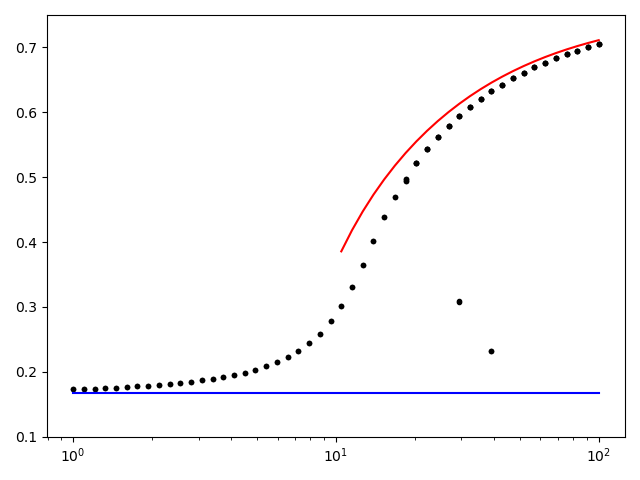

In [32]:
fig, ax = plt.subplots()
ax.plot(EJ_values, np.abs(np.reshape(g_numeric, [len(EJ_values), 16])),'.k')
ax.plot(EJ_values[25:], g_fq_limit[25:], 'r')
ax.plot(EJ_values, g_r_limit,'b')
#ax.set_ylabel(r'$')
#ax.set_xlabel(r'$')
#ax.set_title(r'$')
ax.set_xscale('log')
ax.set_ylim([0.1,0.75])
fig.tight_layout()
fig.show()
plt.close('all')

In [209]:
## Testings
Δ=1
fluxonium = sq_ext.sq_fluxonium(Csh=Csh, C=C, CJ=CJ, Lq=Lq, Lr=Lr, EJ=EJ, Δ=Δ)
resonator = sq_ext.sq_resonator(Csh=Csh, C=C, CJ=CJ, Lq=Lq, Lr=Lr, EJ=EJ, Δ=Δ)

H_0 = sq_ext.hamiltonian_qubit(fluxonium = fluxonium, resonator = resonator, Δ=0) 
H   = sq_ext.hamiltonian_qubit(fluxonium = fluxonium, resonator = resonator, Δ=Δ) 

H_eff_p1 = sq_ext.H_eff_p1(H_0, H, 5, real = True, remove_ground=True)
H_eff_p1

array([[0.000000000000, -0.000000000000, -0.000000000000, 0.000000000000, 0.288619969147],
       [-0.000000000000, 1.956177397661, -0.000000000000, 0.288619969147, -0.000000000000],
       [-0.000000000000, -0.000000000000, 6.175346196283, 0.000000000000, 0.280270993007],
       [0.000000000000, 0.288619969147, 0.000000000000, 7.217187642835, 0.000000000000],
       [0.288619969147, -0.000000000000, 0.280270993007, 0.000000000000, 9.173365040496]])